# Probabilistic solvers as collocation methods

Probabilistic solvers condition a prior distribution on satisfying an ODE on a specified grid.


In [19]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from diffeqzoo import backend, ivps
from jax.config import config

from probdiffeq import dense_output, ivpsolve, solvers
from probdiffeq.implementations import recipes
from probdiffeq.strategies import smoothers

if not backend.has_been_selected:
    backend.select("jax")  # ivp examples in jax


config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

In [2]:
# Make a problem
f, u0, (t0, t1), f_args = ivps.lotka_volterra(time_span=(0.0, 5.0))

f_vect = jax.vmap(f, in_axes=(0, None, None, None, None))


@jax.jit
def vector_field(y, *, t, p):
    return f(y, *p)


# Make a solver
solver = solvers.MLESolver(
    smoothers.Smoother(recipes.VectMM1.from_params(ode_shape=(2,), num_derivatives=1))
)

In [3]:
%%time

# Solve the ODE with low precision
ts = jnp.linspace(t0, t1, endpoint=True, num=10)
solution = ivpsolve.solve(
    vector_field,
    initial_values=(u0,),
    t0=t0,
    t1=t1,
    atol=1e-2,
    rtol=1e-2,
    solver=solver,
    parameters=f_args,
)

CPU times: user 2.34 s, sys: 24.8 ms, total: 2.37 s
Wall time: 2.33 s


In [21]:
# Evalate the posterior on a dense grid

eps = 1e-4
mesh = jnp.linspace(t0 + eps, t1 - eps, endpoint=True)
_, marginals = dense_output.offgrid_marginals_searchsorted(
    ts=mesh, solution=solution, solver=solver
)

u = marginals.marginal_nth_derivative(0)
du = marginals.marginal_nth_derivative(1)

In [12]:
# Extrapolate the prior on the dense grid

extrapolation_model = solver.strategy.implementation.extrapolation
taylor_coefficients = jnp.reshape(
    solution.marginals.hidden_state.mean[0, ...],
    solution.marginals.target_shape,
    order="F",
)


def extrapolate_fn(rv, model, dt, scale_sqrtm):
    ssv, cache = model.begin_extrapolation(rv, dt)
    rv = model.complete_extrapolation(
        ssv, p0=rv, cache=cache, output_scale_sqrtm=scale_sqrtm
    )
    return rv


means_u = []
means_du = []
rv = extrapolation_model.init_corrected(taylor_coefficients)
for t_old, t_new in zip(mesh[:-1], mesh[1:]):
    means_u.append(rv.marginal_nth_derivative(0).mean)
    means_du.append(rv.marginal_nth_derivative(1).mean)
    dt = t_new - t_old
    rv = extrapolate_fn(rv, extrapolation_model, dt, 1.0)
means_u.append(rv.marginal_nth_derivative(0).mean)
means_du.append(rv.marginal_nth_derivative(1).mean)

means_u = jnp.asarray(means_u)
means_du = jnp.asarray(means_du)

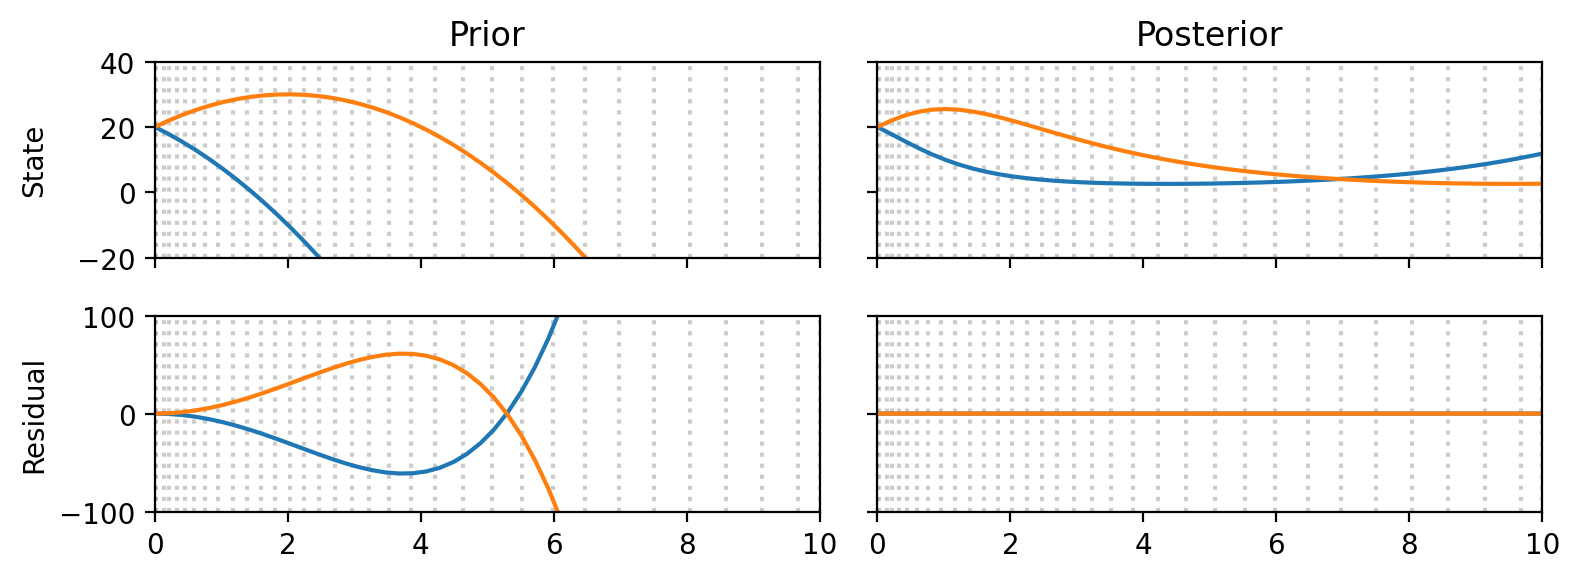

In [18]:
# Plot the samples
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(
    nrows=2, ncols=2, sharex=True, sharey="row", figsize=(8, 3), dpi=200
)
for t in solution.t:
    for ax in (ax0, ax1, ax2, ax3):
        ax.axvline(t, alpha=0.2, color="k", linestyle="dotted")

ax0.set_title("Prior")
ax1.set_title("Posterior")
ax0.set_ylabel("State")
ax2.set_ylabel("Residual")
ax0.plot(mesh, means_u)
ax1.plot(mesh, u.mean)
ax2.plot(mesh, means_du - f_vect(means_u, *f_args))
ax3.plot(mesh, du.mean - f_vect(u.mean, *f_args))

ax0.set_xlim((t0, t1))
ax0.set_ylim((-20, 40))
ax2.set_ylim((-100, 100))

plt.tight_layout()
fig.align_ylabels()
plt.show()

The prior state estimate (top left) has a large residual $\dot u - f(u)$. By conditioning on satisfying a zero residual (bottom left to bottom right), the state estimate becomes a useful ODE solution (top right).